In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# 设置随机种子，保证结果可复现
np.random.seed(42)

# 定义参数
n_samples = 10000  # 总样本数
n_features = 500   # 特征维度
train_size = 7000  # 训练集大小
test_size = 3000   # 测试集大小
noise_std = 1.0 
# 生成特征数据 X (服从均匀分布或正态分布，这里选择正态分布)
# X = np.random.randn(n_samples, n_features)  # 形状为 (10000, 500)
X = np.random.randn(n_samples, n_features).astype(np.float32)

# 生成误差项 epsilon (服从均值为0的正态分布)
# epsilon = np.random.randn(n_samples)  # 形状为 (10000,)
epsilon = np.random.randn(n_samples).astype(np.float32) * noise_std

# 计算目标值 y，根据公式 y = 0.028 + sum(0.0056 * x_i) + epsilon
# 先计算特征的线性组合部分
linear_combination = 0.0056 * np.sum(X, axis=1)  # 对每行特征求和后乘以系数
y = 0.028 + linear_combination + epsilon  # 加上偏置项和误差项

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, 
    test_size=test_size, 
    random_state=42  # 固定随机状态，确保划分一致
)


print(f"数据集生成完成：")
print(f"训练集形状: X={X_train.shape}, y={y_train.shape}")
print(f"测试集形状: X={X_test.shape}, y={y_test.shape}")

数据集生成完成：
训练集形状: X=(7000, 500), y=(7000,)
测试集形状: X=(3000, 500), y=(3000,)


In [3]:
class FeedForwardNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001):
        """
        初始化神经网络参数
        :param input_dim: 输入特征维度（这里是500）
        :param hidden_dim: 隐藏层神经元数量
        :param output_dim: 输出维度（回归问题为1）
        :param learning_rate: 学习率
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate
        
        # 修复：正确的权重初始化
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

    def relu(self, x):
        """激活函数：ReLU（隐藏层用）"""
        return np.maximum(0, x)

    def relu_deriv(self, x):
        """ReLU的导数（用于反向传播）"""
        return np.where(x > 0, 1, 0)

    def forward(self, X):
        """前向传播：计算网络输出"""
        # 隐藏层计算
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # 输出层计算
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.y_pred = self.z2
        return self.y_pred

    def backward(self, X, y_true):
        """反向传播：计算梯度并更新参数"""
        m = X.shape[0]
        
        # 修复：确保y_true的维度正确
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        
        # 输出层误差
        delta2 = (self.y_pred - y_true) / m  # 形状: (batch_size, output_dim)
        
        # 修复：隐藏层误差计算
        delta1 = np.dot(delta2, self.W2.T) * self.relu_deriv(self.z1)  # 形状: (batch_size, hidden_dim)
        
        # 计算梯度
        dW2 = np.dot(self.a1.T, delta2)  # 形状: (hidden_dim, output_dim)
        db2 = np.sum(delta2, axis=0, keepdims=True)  # 形状: (1, output_dim)
        dW1 = np.dot(X.T, delta1)  # 形状: (input_dim, hidden_dim)
        db1 = np.sum(delta1, axis=0, keepdims=True)  # 形状: (1, hidden_dim)
        
        # 更新参数
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y, epochs, batch_size=32, X_test=None, y_test=None, verbose=True):
        """训练网络
        :param X: 训练特征
        :param y: 训练标签
        :param epochs: 训练轮次
        :param batch_size: 批次大小
        :param X_test: 测试特征（可选）
        :param y_test: 测试标签（可选）
        :param verbose: 是否打印训练过程
        :return: 训练历史记录
        """
        m = X.shape[0]
        
        # 修复：确保y是二维数组
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # 初始化历史记录
        history = {
            'train_loss': [],
            'test_loss': [],
            'epochs': []
        }
        
        for epoch in range(epochs):
            # 打乱数据
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # 批量训练
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # 前向传播
                self.forward(X_batch)
                # 反向传播
                self.backward(X_batch, y_batch)
            
            # 每个epoch结束后记录损失
            if (epoch + 1) % 1 == 0:  # 每个epoch都记录，可以调整为每N个epoch
                # 训练集损失
                y_pred_train = self.forward(X)
                train_loss = mean_squared_error(y, y_pred_train)
                
                # 测试集损失（如果提供了测试集）
                test_loss = None
                if X_test is not None and y_test is not None:
                    y_pred_test = self.forward(X_test)
                    test_loss = mean_squared_error(y_test, y_pred_test)
                
                # 记录历史
                history['train_loss'].append(train_loss)
                history['test_loss'].append(test_loss)
                history['epochs'].append(epoch + 1)
                
                # 打印信息
                if verbose and (epoch + 1) % 10 == 0:
                    if test_loss is not None:
                        print(f"Epoch {epoch+1}/{epochs}, 训练MSE: {train_loss:.6f}, 测试MSE: {test_loss:.6f}")
                    else:
                        print(f"Epoch {epoch+1}/{epochs}, 训练MSE: {train_loss:.6f}")
        
        return history

    def predict(self, X):
        """预测方法"""
        return self.forward(X)

In [4]:
if __name__ == "__main__":
    # 初始化神经网络（输入500维，隐藏层128个神经元，输出1维）
    model = FeedForwardNN(
        input_dim=n_features,
        hidden_dim=128,
        output_dim=1,
        learning_rate=0.001
    )
    
    # 训练模型
    print("开始训练...")
    history = model.train(
        X=X_train,
        y=y_train,
        epochs=500,  # 训练轮次
        batch_size=64,  # 批次大小
        X_test=X_test,
        y_test=y_test
    )
    
    # 在测试集上评估
    y_pred_test = model.forward(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    print(f"\n测试集MSE损失: {test_mse:.6f}")
    print(f"测试集RMSE: {np.sqrt(test_mse):.6f}")

开始训练...
Epoch 10/500, 训练MSE: 1.217405, 测试MSE: 1.277883
Epoch 20/500, 训练MSE: 1.067249, 测试MSE: 1.144208
Epoch 30/500, 训练MSE: 1.019320, 测试MSE: 1.103788
Epoch 40/500, 训练MSE: 0.996355, 测试MSE: 1.089817
Epoch 50/500, 训练MSE: 0.981844, 测试MSE: 1.084576
Epoch 60/500, 训练MSE: 0.970018, 测试MSE: 1.084230
Epoch 70/500, 训练MSE: 0.959538, 测试MSE: 1.088792
Epoch 80/500, 训练MSE: 0.947231, 测试MSE: 1.090464
Epoch 90/500, 训练MSE: 0.934977, 测试MSE: 1.094182
Epoch 100/500, 训练MSE: 0.921762, 测试MSE: 1.101035
Epoch 110/500, 训练MSE: 0.907868, 测试MSE: 1.108080
Epoch 120/500, 训练MSE: 0.893173, 测试MSE: 1.118322
Epoch 130/500, 训练MSE: 0.877314, 测试MSE: 1.126336
Epoch 140/500, 训练MSE: 0.860605, 测试MSE: 1.137217
Epoch 150/500, 训练MSE: 0.843038, 测试MSE: 1.148689
Epoch 160/500, 训练MSE: 0.824522, 测试MSE: 1.160692
Epoch 170/500, 训练MSE: 0.804911, 测试MSE: 1.173007
Epoch 180/500, 训练MSE: 0.784240, 测试MSE: 1.186636
Epoch 190/500, 训练MSE: 0.762359, 测试MSE: 1.200545
Epoch 200/500, 训练MSE: 0.739202, 测试MSE: 1.215790
Epoch 210/500, 训练MSE: 0.714851, 测试MSE: 1.

In [5]:
def plot_training_history(history):
    """绘制训练和测试损失变化图"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    # 绘制训练损失
    plt.plot(history['epochs'], history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    
    # 如果存在测试损失，也绘制出来
    if any(loss is not None for loss in history['test_loss']):
        plt.plot(history['epochs'], history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Changes in Training and Testing Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # 使用对数坐标更好地观察损失变化
    plt.tight_layout()
    plt.show()

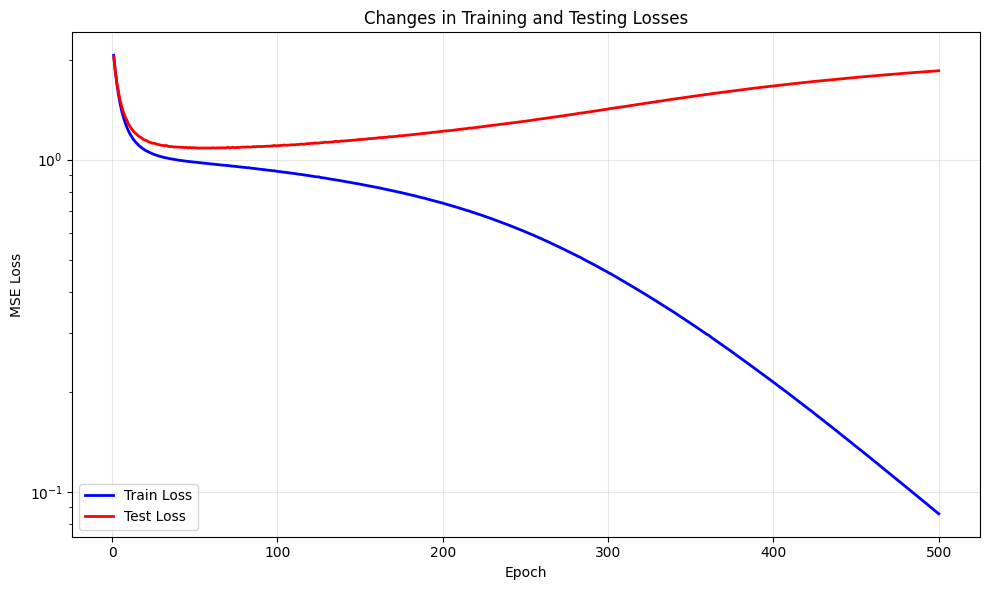

最终测试集MSE: 1.850336
最佳测试性能 - Epoch: 59, 测试MSE: 1.082802


In [6]:
plot_training_history(history)

# 在测试集上最终评估
y_pred_test = model.predict(X_test)
final_test_mse = mean_squared_error(y_test, y_pred_test)
print(f"最终测试集MSE: {final_test_mse:.6f}")

# 查看最佳epoch
if any(loss is not None for loss in history['test_loss']):
    best_epoch = np.argmin(history['test_loss'])
    best_test_loss = history['test_loss'][best_epoch]
    print(f"最佳测试性能 - Epoch: {best_epoch + 1}, 测试MSE: {best_test_loss:.6f}")

In [7]:

class RegularizedFeedForwardNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001, 
                 dropout_rate=0.2, l2_lambda=0.01):
        """
        改进的神经网络，添加正则化防止过拟合
        :param input_dim: 输入特征维度
        :param hidden_dim: 隐藏层神经元数量
        :param output_dim: 输出维度
        :param learning_rate: 学习率
        :param dropout_rate: Dropout率 (0-1之间，0表示不使用dropout)
        :param l2_lambda: L2正则化系数
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        
        # 初始化权重和偏置
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

    def relu(self, x):
        """激活函数：ReLU"""
        return np.maximum(0, x)

    def relu_deriv(self, x):
        """ReLU的导数"""
        return np.where(x > 0, 1, 0)

    def dropout(self, X, rate):
        """Dropout实现"""
        if rate > 0:
            # 生成掩码
            self.mask = np.random.binomial(1, 1-rate, size=X.shape) / (1-rate)
            return X * self.mask
        return X

    def forward(self, X, is_training=True):
        """前向传播
        :param is_training: 是否为训练模式（影响dropout应用）
        """
        # 隐藏层计算
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # 应用Dropout（仅在训练时）
        if is_training:
            self.a1_dropout = self.dropout(self.a1, self.dropout_rate)
        else:
            self.a1_dropout = self.a1
        
        # 输出层计算
        self.z2 = np.dot(self.a1_dropout, self.W2) + self.b2
        self.y_pred = self.z2
        return self.y_pred

    def backward(self, X, y_true):
        """反向传播（包含L2正则化）"""
        m = X.shape[0]
        
        # 确保y_true的维度正确
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        
        # 输出层误差
        delta2 = (self.y_pred - y_true) / m
        
        # 隐藏层误差（考虑dropout掩码）
        if hasattr(self, 'mask'):
            delta1 = np.dot(delta2, self.W2.T) * self.relu_deriv(self.z1) * self.mask
        else:
            delta1 = np.dot(delta2, self.W2.T) * self.relu_deriv(self.z1)
        
        # 计算梯度（添加L2正则化项）
        dW2 = np.dot(self.a1_dropout.T, delta2) + (self.l2_lambda / m) * self.W2
        db2 = np.sum(delta2, axis=0, keepdims=True)
        dW1 = np.dot(X.T, delta1) + (self.l2_lambda / m) * self.W1
        db1 = np.sum(delta1, axis=0, keepdims=True)
        
        # 更新参数
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y, epochs, batch_size=32, X_test=None, y_test=None, 
              verbose=True, early_stopping=True, patience=20):
        """训练网络（添加早停功能）
        :param early_stopping: 是否使用早停
        :param patience: 早停耐心值（多少个epoch没有改善后停止）
        """
        m = X.shape[0]
        
        # 确保y是二维数组
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        
        # 初始化历史记录
        history = {
            'train_loss': [],
            'test_loss': [],
            'epochs': []
        }
        
        # 早停相关变量
        best_test_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in range(epochs):
            # 打乱数据
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # 批量训练
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # 前向传播（训练模式）
                self.forward(X_batch, is_training=True)
                # 反向传播
                self.backward(X_batch, y_batch)
            
            # 每个epoch结束后记录损失
            # 训练集损失（使用训练模式）
            y_pred_train = self.forward(X, is_training=True)
            train_loss = mean_squared_error(y, y_pred_train)
            
            # 测试集损失（使用评估模式，不应用dropout）
            test_loss = None
            if X_test is not None and y_test is not None:
                y_pred_test = self.forward(X_test, is_training=False)
                test_loss = mean_squared_error(y_test, y_pred_test)
                
                # 早停逻辑
                if early_stopping:
                    if test_loss < best_test_loss:
                        best_test_loss = test_loss
                        patience_counter = 0
                        # 保存最佳权重
                        best_weights = {
                            'W1': self.W1.copy(),
                            'b1': self.b1.copy(),
                            'W2': self.W2.copy(),
                            'b2': self.b2.copy()
                        }
                    else:
                        patience_counter += 1
                    
                    # 检查是否触发早停
                    if patience_counter >= patience:
                        print(f"早停触发，在第 {epoch+1} 个epoch停止训练")
                        # 恢复最佳权重
                        if best_weights is not None:
                            self.W1 = best_weights['W1']
                            self.b1 = best_weights['b1']
                            self.W2 = best_weights['W2']
                            self.b2 = best_weights['b2']
                        break
            
            # 记录历史
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['epochs'].append(epoch + 1)
            
            # 打印信息
            if verbose and (epoch + 1) % 10 == 0:
                if test_loss is not None:
                    print(f"Epoch {epoch+1}/{epochs}, 训练MSE: {train_loss:.6f}, 测试MSE: {test_loss:.6f}")
                else:
                    print(f"Epoch {epoch+1}/{epochs}, 训练MSE: {train_loss:.6f}")
        
        return history

    def predict(self, X):
        """预测方法（使用评估模式）"""
        return self.forward(X, is_training=False)

Epoch 10/500, 训练MSE: 1.193844, 测试MSE: 1.162041
Epoch 20/500, 训练MSE: 1.048701, 测试MSE: 1.069538
Epoch 30/500, 训练MSE: 1.024065, 测试MSE: 1.054402
Epoch 40/500, 训练MSE: 1.020951, 测试MSE: 1.053371
Epoch 50/500, 训练MSE: 1.016238, 测试MSE: 1.049681
Epoch 60/500, 训练MSE: 1.013675, 测试MSE: 1.052206
Epoch 70/500, 训练MSE: 1.016647, 测试MSE: 1.048399
Epoch 80/500, 训练MSE: 1.009105, 测试MSE: 1.051199
Epoch 90/500, 训练MSE: 1.008454, 测试MSE: 1.053039
早停触发，在第 99 个epoch停止训练


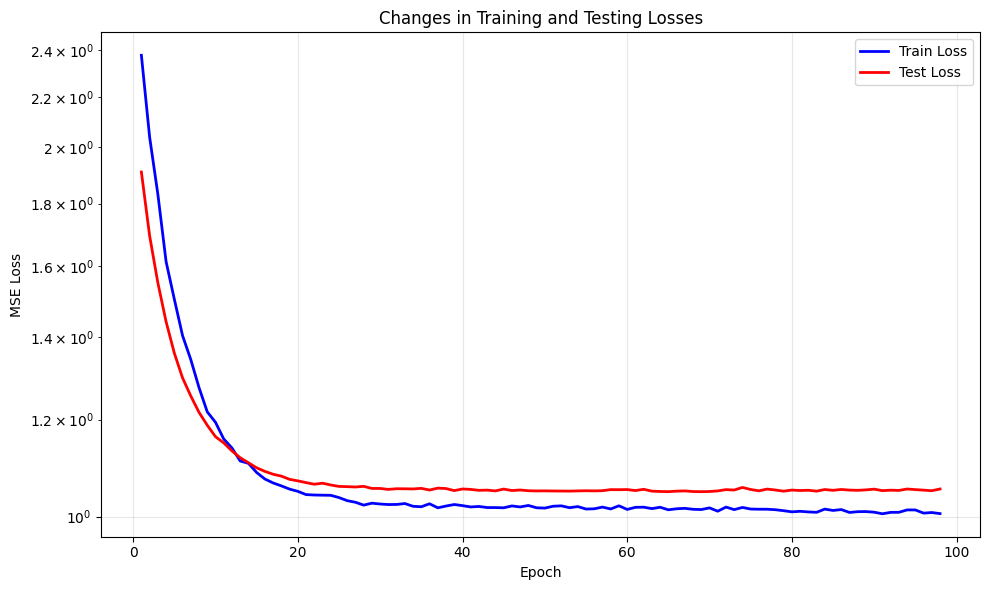

最终测试集MSE: 1.048077
最佳测试性能 - Epoch: 69, 测试MSE: 1.048077


In [9]:
# 创建正则化模型
model = RegularizedFeedForwardNN(
    input_dim=500, 
    hidden_dim=128, 
    output_dim=1, 
    learning_rate=0.001,
    dropout_rate=0.3,      # 30%的神经元被丢弃
    l2_lambda=0.001        # L2正则化系数
)

# 训练模型
history_1 = model.train(
    X=X_train,
    y=y_train,
    epochs=500,            # 可以训练更多轮次而不用担心过拟合
    batch_size=64,
    X_test=X_test,
    y_test=y_test,
    early_stopping=True,   # 启用早停
    patience=30            # 30个epoch没有改善就停止
)

# 预测
# y_pred = model.predict(X_test)

plot_training_history(history_1)

# 在测试集上最终评估
y_pred_test = model.predict(X_test)
final_test_mse = mean_squared_error(y_test, y_pred_test)
print(f"最终测试集MSE: {final_test_mse:.6f}")

# 查看最佳epoch
if any(loss is not None for loss in history['test_loss']):
    best_epoch = np.argmin(history_1['test_loss'])
    best_test_loss = history_1['test_loss'][best_epoch]
    print(f"最佳测试性能 - Epoch: {best_epoch + 1}, 测试MSE: {best_test_loss:.6f}")